In [20]:
cd drive/

[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [21]:
cd My\ Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [22]:
cd Plate_detect_and_recognize-master/

[Errno 2] No such file or directory: 'Plate_detect_and_recognize-master/'
/content/drive/My Drive/Plate_detect_and_recognize-master


In [23]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
import math

In [24]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [25]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [26]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [27]:
def basic_method(plate_image):
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    return [plate_image, gray, blur, binary, thre_mor]
    # returnArray.append([plate_image, gray, blur, binary, thre_mor])

def color_method(colorNumber, plate_image):
  possibleImages = []
  # image = cv2.imread("color2.png")
  b = plate_image.copy()
#   # return copy.shape
  b = b[:, :, colorNumber]
  y = math.floor(b.shape[0]/2.4)
  x = math.floor(b.shape[1]/9)
  crop_img = b[y:int(y*2), x:int(x*8.3)]
  # plt.imshow(crop_img)
  b = cv2.GaussianBlur(b,(7,7),0)
  flatArray = b.flatten()
  cangeV =  np.percentile(flatArray, [32])
  image = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  # # convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  _, binary = cv2.threshold(gray, cangeV, cangeV, cv2.THRESH_BINARY_INV)


  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  blur = cv2.GaussianBlur(gray,(7,7),0)
  
  # Applied inversed thresh_binary 
  binary = cv2.threshold(blur, 180, 255,
                        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
  # plt.imshow(thre_mor)
  return [plate_image, gray, blur, binary, thre_mor]

def visualize_set(plot_image):
  # visualize results    
  fig = plt.figure(figsize=(12,7))
  plt.rcParams.update({"font.size":18})
  grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
  # plot_image = [plate_image, gray, blur, binary,thre_mor]
  plot_name = ["plate_image","gray","blur","binary","dilation"]

  for i in range(len(plot_image)):
      fig.add_subplot(grid[i])
      plt.axis(False)
      plt.title(plot_name[i])
      plt.imshow(plot_image[i])
      # if i ==0:
      #     plt.imshow(plot_image[i])
      # else:
      #     plt.imshow(plot_image[i],cmap="gray")



def getFilteredPlateImages(path):

  returnArray = []

  test_image_path = path
  vehicle, LpImg,cor = get_plate(test_image_path)

  if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    returnArray.append(basic_method(plate_image))

    for i in range(3):
      returnArray.append(color_method(i,plate_image))

    # plt.imshow(returnArray[0][4])

    # visualize_set(returnArray[0])

    # visualize_set(returnArray[1])
  return returnArray

filteredPlateImages =  getFilteredPlateImages("Plate_examples/photo2.JPG")
# filteredPlateImages =  getFilteredPlateImages("Plate_examples/germany_car_plate.jpg")

Detect 6 letters...


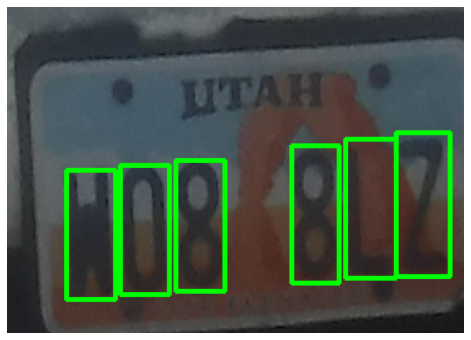

In [28]:
import statistics
import numpy as np
from sklearn.linear_model import LinearRegression

def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

def fineChopLetters(contours):
  # return contours
  heightList = []
  # absHeightList 
  go = True
  rScore = .05
  passing = 0
  while(rScore < .9 and passing < 6):
    heightList = []
    heightList = [con[1] - con[0] for con in contours]
    average = np.mean(heightList)
    if abs(rScore) < .85:
      heightDifList = [abs(cow - average) for cow in heightList]
      indexToRemove = np.argmax(heightDifList)
      xPointOfInterest = np.array([(contours[indexToRemove][2] + contours[indexToRemove][3]) / 2])
      xPointOfInterest = xPointOfInterest.reshape(1,-1)
      tempContorCopy = contours.copy()
      del tempContorCopy[indexToRemove]
      bottomEdge = [((con[2] + con[3])/2, con[0]) for con in tempContorCopy ]
      topEdge = [((con[2] + con[3])/2, con[1]) for con in tempContorCopy ]

      X = [((con[2] + con[3])/2) for con in tempContorCopy ]
      X = np.array(X).reshape((-1, 1))

      model = LinearRegression()

      bottomEdgeY = np.array([con[0] for con in tempContorCopy ])
      model.fit(X, bottomEdgeY)
      newYValue = model.predict(xPointOfInterest)
      contours[indexToRemove][0] = int(newYValue)
      rSq1 = model.score(X, bottomEdgeY)

      topEdgeY = np.array([con[1] for con in tempContorCopy ])
      model.fit(X, topEdgeY)
      newYValue = model.predict(xPointOfInterest)
      contours[indexToRemove][1] = int(newYValue)
      rSq2 = model.score(X, topEdgeY)
      rScore = (rSq1 + rSq2) / 2
      passing += 1
    else:
      go = False

  # [[100, 179, 36, 66], [96, 193, 69, 99], [94, 174, 103, 133], [85, 169, 174, 203], [88, 182, 207, 238], [77, 165, 238, 271]]
   
  return contours

def getContorSets(filteredImages):

  contour_sets = []

  for imageSet in filteredImages:
    
    plate_image = imageSet[0]

    binary = imageSet[3]
    thre_mor = imageSet[4]

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []
    small_letters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    # [ndarray with shape (3, 1, 2), ndarray with shape (4, 1, 2), ndarray with shape 
    #  (6, 1, 2), ndarray with shape (5, 1, 2), ndarray with shape (7, 1, 2), ...] (21 items total)
    # return cont
    # print(plate_image.shape)
    totalArea = plate_image.shape[0] * plate_image.shape[1]
    # for c in sort_contours(cont):
        
    #     (x, y, w, h) = cv2.boundingRect(c)
    #     ratio = h/w
    #     contorArea = x*h
    #     # print(contorArea/totalArea)
    #     if .02 < contorArea/totalArea < .07: # Only select contour with small area
    #       if y > plate_image.shape[0] *.55 or y + h < plate_image.shape[0] *.45: #only select contor not in middle
    #         if (x + w) < plate_image.shape[1] * .75: #only select if width is relatively small
    #           cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

    #           # Sperate number and gibe prediction
    #           curr_num = thre_mor[y:y+h,x:x+w]
    #           curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
    #           _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #           small_letters.append(curr_num)
    count = 0
    curr_num_list = []
    for c in sort_contours(cont):
        # cout = count + 1
        # if count == 2
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if .9<=ratio<=4: # Only select contour with defined ratio
          if y < plate_image.shape[0] *.6 and y + h > plate_image.shape[0] *.4: #only select contor in middle
            # if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
            
            curr_num_list.append([y,y+h,x,x+w])
            # Sperate number and gibe prediction

    if(len(curr_num_list) > 1):
      curr_num_list = fineChopLetters(curr_num_list)
        # [[100, 179, 36, 66], [96, 193, 69, 99], [94, 174, 103, 133], [85, 169, 174, 203], [88, 182, 207, 238], [77, 165, 238, 271]]
      for curr in curr_num_list:
        cv2.rectangle(test_roi, (curr[2], curr[0]), (curr[3], curr[1]), (0, 255,0), 2)
        # cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
        curr_num = thre_mor[curr[0]:curr[1],curr[2]:curr[3]]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        crop_characters.append(curr_num)

      # crop_characters = fineChopLetters(crop_characters)
      print("Detect {} letters...".format(len(crop_characters)))
      fig = plt.figure(figsize=(10,6))
      plt.axis(False)
      plt.imshow(test_roi)
      # return curr_num_list
      contour_sets.append(crop_characters)

  return contour_sets

crop_characters_set = getContorSets(filteredPlateImages)

In [29]:
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')


U088LZ


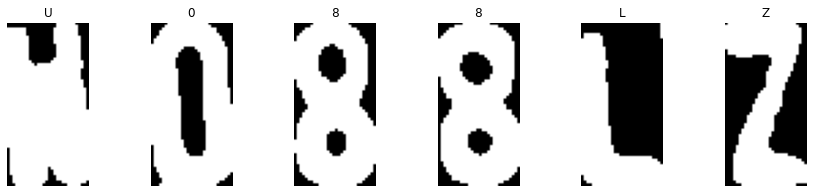

In [30]:
def predict_from_model(image,model,labels):
    plt.imshow(image)
    # return
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

def read_letters(crop_characters_set):
  for chop_characters2 in crop_characters_set:
    fig = plt.figure(figsize=(15,3))
    cols = len(chop_characters2)
    grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

    final_string = ''
    for i,character in enumerate(chop_characters2):
        fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,model,labels))
        plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
        plt.axis(False)
        plt.imshow(character,cmap='gray')

    print(final_string)
read_letters(crop_characters_set)